### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import nltk.data
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

### Define useful functions

In [2]:
def text_process_prelim(review_sentence):
    review_sentence_str = str(review_sentence)
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in review_sentence_str if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    if nopunc == '':
        return np.nan
    else:
        return nopunc
    
def text_process(review_sentence):
    return [word.lower() for word in review_sentence.split()]

### Import dataset

In [15]:
df_preprocessed = pd.read_csv('./datasets/df_preprocessed.csv')

### Normalization (punctuation)

In [17]:
df_preprocessed['review_sentence'] = df_preprocessed['review_sentence'].apply(text_process_prelim)

In [19]:
df_preprocessed['review_item_header_content'] = df_preprocessed['review_item_header_content'].apply(text_process_prelim)

### Remove reviews that are now empty

In [20]:
df_preprocessed = df_preprocessed[~pd.isnull(df_preprocessed['review_sentence'])]

In [21]:
len(df_preprocessed)

491198

### Print out negative review sentences to csv file for topic labeling

In [22]:
df_preprocessed_neg_sentences = df_preprocessed[df_preprocessed['review_label']==0]
df_preprocessed_neg_sentences['review_topic'] = np.nan
df_preprocessed_neg_sentences.iloc[:,:].to_csv('./datasets/df_negative_sentences.csv',index=False)

<ipython-input-22-e7bb6f313408>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed_neg_sentences['review_topic'] = np.nan


# Modeling

## Create model pipeline: Vectorization (BoW), TF-IDF, Naive Bayes Classifier

In [47]:
model_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB())  # train on TF-IDF vectors w/ Naive Bayes classifier
])

## Train-validation split

In [48]:
df_preprocessed_features = df_preprocessed.drop('review_label', axis=1)

In [49]:
df_train, df_valid, label_train, label_valid = train_test_split(df_preprocessed_features, df_preprocessed['review_label'], test_size=0.2)

## Train model

In [50]:
# using only review_sentence as feature (so for instance no review sentence length)
# df_preprocessed['review_sentence_length'] = df_preprocessed['review_sentence'].apply(len)

In [51]:
model_pipeline.fit(df_train['review_sentence'],label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f95677bce50>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

## Validate model

In [52]:
predictions = model_pipeline.predict(df_valid['review_sentence'])

### Print classification report

In [53]:
print(classification_report(label_valid,predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     47272
           1       0.88      0.81      0.84     50971

    accuracy                           0.84     98243
   macro avg       0.84      0.84      0.84     98243
weighted avg       0.85      0.84      0.84     98243



### Print confusion matrix

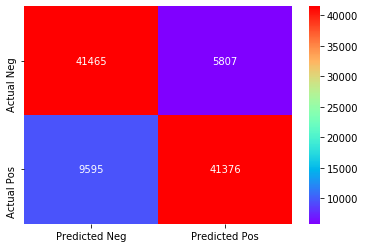

In [54]:
valid_cm = confusion_matrix(label_valid,predictions)
valid_cm_tn, valid_cm_fp, valid_cm_fn, valid_cm_tp = valid_cm.ravel()
valid_cm_pd = pd.DataFrame(data=valid_cm,columns=['Predicted Neg','Predicted Pos'],index=['Actual Neg', 'Actual Pos'])
sns.heatmap(valid_cm_pd, annot=True, fmt='d', cmap='rainbow')
plt.show()

In [121]:
#######################################################################

### Vectorization (BoW)

In [65]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_preprocessed['review_sentence'])

In [66]:
# print length of vocabulary
print(len(bow_transformer.vocabulary_))

35955


In [71]:
review_sentence_bow = bow_transformer.transform(df_preprocessed['review_sentence'])

In [79]:
# print info about sparsity
review_sentence_bow_sparsity = (100.0 * review_sentence_bow.nnz / (review_sentence_bow.shape[0] * review_sentence_bow.shape[1]))
print('Shape of Sparse Matrix: ', review_sentence_bow.shape)
print('Amount of Non-Zero occurrences: ', review_sentence_bow.nnz)
print('Sparsity: {} %'.format(round(sparsity,3)))

Shape of Sparse Matrix:  (414282, 35955)
Amount of Non-Zero occurrences:  3889186
Sparsity: 0.026 %


### TF-IDF

In [80]:
tfidf_transformer = TfidfTransformer().fit(review_sentence_bow)

In [82]:
review_sentence_tfidf = tfidf_transformer.transform(review_sentence_bow)

### Naive Bayes Classifier

In [ ]:
nb_model = MultinomialNB().fit(review_sentence_tfidf, messages['label'])